# A simple logistic regression classifier

In [14]:
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect
import math

import sys
sys.path.append(os.path.abspath('streamlined_mop/src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio, get_val_data

/home/sultand/mop_modifications


In [2]:
def logistic(x,beta):
    # x is a vector of size p + 1
    # beta is a vector of size p + 1
    # returns the logistic function
    return np.exp(np.dot(x,beta))/(1+np.exp(np.dot(x,beta)))

def gradl(x,y,beta):
    # x is a matrix of size N x (p+1)
    # y is a vector of size N
    # beta is a vector of size p + 1
    # returns the gradient of the log-likelihood function
    # print("shape of logistic(x,beta) = ",logistic(x,beta).shape)
    # print("shape of y = ",y.shape)
    # print("shape of x = ",x.shape)
    grad = np.dot(x.T,y-logistic(x,beta))
    return grad

def hessl(x,beta):
    # x is a matrix of size N x (p+1)
    # y is a vector of size N
    # beta is a vector of size p + 1
    # returns the hessian of the log-likelihood function
    hess = -x.T.dot(np.diag(logistic(x,beta)*(1-logistic(x,beta)))).dot(x)
    return hess

In [18]:
def newton_decrement_square(x,y,beta):
    # x is a matrix of size N x (p+1)
    # y is a vector of size N
    # beta is a vector of size p + 1
    # returns the Newton decrement squared
    try:
        out = np.dot(gradl(x,y,beta).T,np.linalg.inv(hessl(x,beta)).dot(gradl(x,y,beta)))

    except LinAlgError as e:
        print(f"Hessian is a {e} error occured. Adding epsilon to diagonal.")
        eps = 1e-3

        hess = hessl(x,beta)

        new_hess = hess + eps*np.eye(len(hess))
        out = np.dot(gradl(x,y,beta).T,np.linalg.inv(new_hess).dot(gradl(x,y,beta)))
        
    return out

def newton(x,y,beta0, step_size, stop_criterion):
    # x is a matrix of size N x (p+1)
    # y is a vector of size N
    # beta0 is a vector of size p + 1
    # returns the estimated beta
    beta = beta0
    training_loss = []
    while -0.5*newton_decrement_square(x,y,beta)>stop_criterion:
        try:
            beta = beta - step_size*np.linalg.inv(hessl(x,beta)).dot(gradl(x,y,beta))
        except LinAlgError as e:
            print(f"Hessian is a {e} occured when computing weights. Adding epsilon to diagonal.")
            eps = 1e-3

            hess = hessl(x,beta)

            new_hess = hess + eps*np.eye(len(hess))
            beta = beta - step_size*np.linalg.inv(new_hess).dot(gradl(x,y,beta))

        current_loss = -np.sum(y*np.log(logistic(x,beta))+(1-y)*np.log(1-logistic(x,beta)))
        print("log loss:", current_loss)
        training_loss.append(current_loss)
    return beta, training_loss

In [4]:
trainA = "upperTriA" #"unifA" #"gaussA" #"gaussA_noscale" #"rotDiagA" #"rotDiagA_unif" #"rotDiagA_gauss" #"upperTriA" #"single_system" #"cond_num" #"mix_gauss_upptri_rotdiag"
valA = "upperTriA" #"unifA" #"gaussA" #"gaussA_noscale" #"rotDiagA" #"rotDiagA_unif" #"rotDiagA_gauss" #"upperTriA" #"single_system" #"cond_num"
num_val_systems = 1000
context_len = 250
nx = 20
print("nx:", nx)

print('context_len:', context_len)
print('trainA:', trainA)
print('valA:', valA)
print("num_val_systems:", num_val_systems)
C_dist = "_gauss_C" #"_unif_C" #"_gauss_C" #"_gauss_C_large_var" #"_single_system"
experiments = ["241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_025241.7a9db9_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_40000"]#, "241107_233959.102bf2_gaussA_gauss_C_mix_lr_0"]#, "241117_204226.922f5f_rotDiagA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"]
print("experiment strings:", experiments)

nx: 20
context_len: 250
trainA: upperTriA
valA: upperTriA
num_val_systems: 1000
experiment strings: ['241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000', '241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000', '241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000', '241124_025241.7a9db9_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_40000']


In [5]:
def pairwise_mul(array, n):
    ydim = array.shape[1]
    # Step 1: Slice the array to take the first n elements along axis 0
    sliced_array = array[:n, :]

    # Step 2: Flatten the sliced array
    flattened_array = sliced_array.flatten()

    # Step 3: Reshape the flattened array to shape (5n, 1)
    reshaped_array = flattened_array.reshape(ydim * n, 1)

    outer = reshaped_array@reshaped_array.T

    flatten_out = outer.flatten()
    return flatten_out

#### Create the training examples through Pairwise Multiplication (still need to implement train-test split)

In [6]:
num_train_samples = (2000*2000)*0.05
print(num_train_samples)

d = 2 # Number of elements to take from axis 0

nxs = [3,10,20]
x = []
for i in range(2): #classify first two experiments
    obs = get_val_data(valA, C_dist, experiments[0], nxs[i])
    count = 0
    for trace in obs:
        if count < 0.5 * num_train_samples:
            x.append(pairwise_mul(trace, d))
        else:
            continue

        count += 1

x = np.array(x)


train_set_size = x.shape
print(train_set_size)



200000.0
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/data/val_upperTriA_gauss_C_state_dim_3.pkl
loaded state dim 3 validation obs
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/data/val_upperTriA_gauss_C_state_dim_10.pkl
loaded state dim 10 validation obs
(200000, 100)


In [ ]:
N = train_set_size[0]
p = train_set_size[1]
y = np.concatenate((np.ones(int(N/2)),np.zeros(int(N/2))))
x = np.concatenate((np.ones((N,1)),x),axis=1)

beta0 = np.zeros(p+1)
print("shape of x:", x.shape)
print("shape of y:", y.shape)
print("shape of beta0:", beta0.shape)

shape of y: (200000,)


In [ ]:
# x = x[:,:-1]
# print(x.shape)

(200000, 101)


In [19]:
# Run the Newton method
beta, training_loss = newton(x,y,beta0,0.01,1e-5)
print("len  of training_loss:", len(training_loss))


Hessian is a Singular matrix error occured. Adding epsilon to diagonal.
Hessian is a Singular matrix occured when computing weights. Adding epsilon to diagonal.
log loss: 138493.42826525684
Hessian is a Singular matrix error occured. Adding epsilon to diagonal.
Hessian is a Singular matrix occured when computing weights. Adding epsilon to diagonal.
log loss: 138360.10406721043
Hessian is a Singular matrix error occured. Adding epsilon to diagonal.
Hessian is a Singular matrix occured when computing weights. Adding epsilon to diagonal.
log loss: 138229.36662424894
Hessian is a Singular matrix error occured. Adding epsilon to diagonal.
Hessian is a Singular matrix occured when computing weights. Adding epsilon to diagonal.
log loss: 138101.1241617525
Hessian is a Singular matrix error occured. Adding epsilon to diagonal.
Hessian is a Singular matrix occured when computing weights. Adding epsilon to diagonal.
log loss: 137975.28982342457
Hessian is a Singular matrix error occured. Adding 

/tmp/ipykernel_1217105/1047300236.py:5: RuntimeWarning: overflow encountered in exp
  return np.exp(np.dot(x,beta))/(1+np.exp(np.dot(x,beta)))
/tmp/ipykernel_1217105/1047300236.py:5: RuntimeWarning: invalid value encountered in divide
  return np.exp(np.dot(x,beta))/(1+np.exp(np.dot(x,beta)))
/tmp/ipykernel_1217105/3740954833.py:39: RuntimeWarning: divide by zero encountered in log
  current_loss = -np.sum(y*np.log(logistic(x,beta))+(1-y)*np.log(1-logistic(x,beta)))
/tmp/ipykernel_1217105/3740954833.py:39: RuntimeWarning: invalid value encountered in multiply
  current_loss = -np.sum(y*np.log(logistic(x,beta))+(1-y)*np.log(1-logistic(x,beta)))


log loss: nan
len  of training_loss: 14


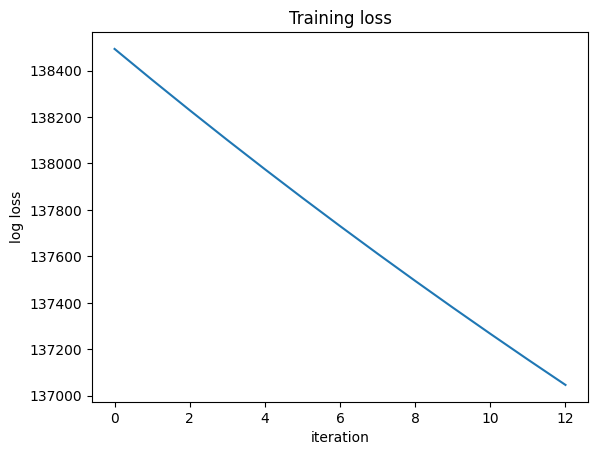

In [20]:
#plot the training loss
plt.plot(range(len(training_loss)), training_loss)
plt.xlabel("iteration")
plt.ylabel("log loss")
plt.title("Training loss")
plt.show()

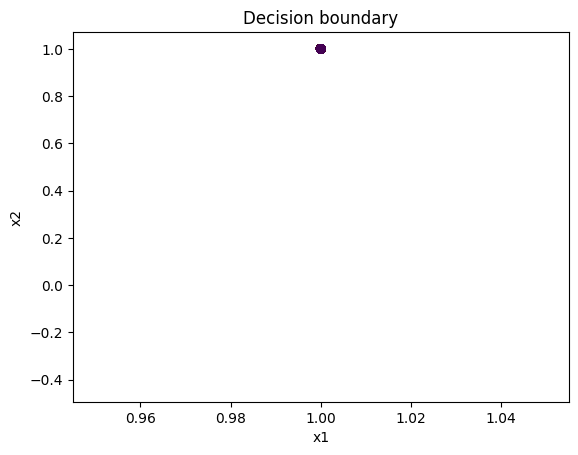

In [ ]:
#plot the decision boundary
plt.scatter(x[:,1],x[:,2],c=y)
plt.plot(x[:,1],-(beta[0]+beta[1]*x[:,1])/beta[2])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Decision boundary")
plt.show()


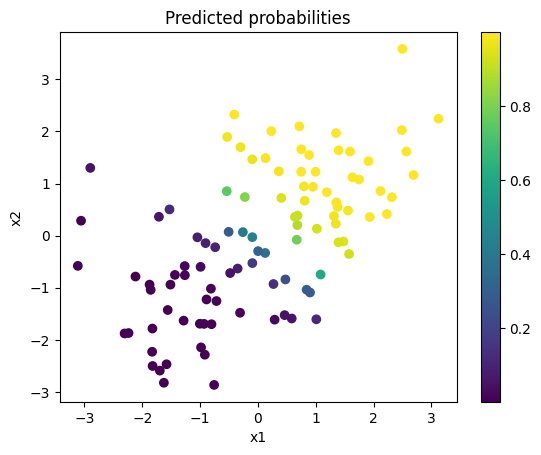

In [173]:
#plot predicted probabilities
plt.scatter(x[:,1],x[:,2],c=logistic(x,beta))
#add colorbar
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Predicted probabilities")
plt.show()